# Association tests between variants and continuous phenotypes
Previously we had learned how to test for association between categorical variables: our variables were genotype and color.

The phenotype data provided in the multi-omics publication is not categorical. We thus have to adapt our approach to deal with continuous data. In the lecture you saw that linear (Pearson's), logistic, or rank-based (Mann-Whitney U) tests can be used when one of the variables is categorical, and the other is continuous.

If the categorical variable is binary, and the continuous variable is normally distributed, a t-test can be used: Student's t-test if the variances of the two groups is identical, and the Welch's t-test otherwise.

In this notebook we will only use Pearson's correlation and the Mann-Whitney U-test.

(And a little note on nomenclature: the conventional name of Pearson's correlation is "point-biserial correlation" if one of the variables is binary. They are exactly the same thing, but if you ever come across the latter, remember that it refers to a special case of Pearson's correlation. Despite our genotypes being *almost* binary, we will keep using the term Pearson's correlation.)

## Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the genotype data
Loading the genotype data is routine by now: separating data from metadata, and converting the B-D-H-U labels into numbers. This time, we will avoid wasting any of our precious data, and instead of dropping strains with too many unknowns, we will work our way around them. We will treat the unknown `U` genotypes as `NaN` values.

In [2]:
# load genetype data
genotype = pd.read_csv("../example_data/aad0189_DataFileS4.txt", sep="\t", comment="@")
genotype.set_index("Locus", inplace=True)
geno_meta = genotype.iloc[:, :3]
geno_bdh = genotype.iloc[:, 3:]
geno = geno_bdh.replace(['B', 'H', 'D', 'U'], [0, 1, 2, np.nan])
geno.columns.name = 'strain'

### Loading the phenotype tables

As for the phenotype spreadsheets, we will always use the `split_cd_hfd(...)`-transformed version from now on. We have provided its code so you don't have to dig it up from Tuesday. Let's convert all sheets with `split_cd_hfd` and forget about it. From now on, the `phenotypes` dictionary will always contain the nice CD/HFD-indexed DataFrames.

In [3]:
#load phenotype
phenotypes_ugly = pd.read_excel('../example_data/aad0189_DataFileS2.xlsx', sheet_name=None, na_values='x', index_col=0)

C:\Users\Tung\PyMOL\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [4]:
# The VO2Max table doesn't follow their own column naming conventions, so we fix that first
def rename_vo2_cols(colname):
    return colname.replace('CD', 'CD_').replace('HFD', 'HFD_').replace('__', '_')

phenotypes_ugly['VO2Max'].rename(columns=rename_vo2_cols, inplace=True)

def split_cd_hfd(input_df):
    input_df.index.name = 'strain'  # change that weird @format=column Excel index label to something meaningful
    input_cd = input_df.filter(regex=r'_CD|CD_') # loc[:, (input_df.columns.str.contains('CD_')) | (input_df.columns.str.contains('_CD'))]
    input_hfd = input_df.filter(regex=r'_HFD|HFD_') #loc[:, (input_df.columns.str.contains('HFD_')) | (input_df.columns.str.contains('_HFD'))]

    input_cd.columns = input_cd.columns.str.replace(r'_CD|CD_', '')
    input_hfd.columns = input_hfd.columns.str.replace(r'_HFD|HFD_', '')
    
    input_cd.insert(0, 'diet', 'CD')
    input_hfd.insert(0, 'diet', 'HFD')
    
    kept_columns = input_cd.columns.intersection(input_hfd.columns)
    kept_columns = input_cd.columns & input_hfd.columns  # this also works
    
    df_both = pd.concat([input_cd, input_hfd], sort=False)[kept_columns]
    df_both.columns.name = 'experiment'  # added only later
    
    return df_both.reset_index().set_index(['strain', 'diet']).sort_index()

In [5]:
# for every sheet (other than the last empty one) we do a split_cd_hfd and then drop
# columns that are admittedly problematic for statistical testing.
# Those columns have "KNOWN_BATCH_EFFECT_BY_COHORT_ORDER" in their names, which we can
# filter out with a tricky regex (sadly .filter() doesn't have an invert=True keyword)

phenotypes = {sheet_name: split_cd_hfd(sheet).filter(regex=r'^(?!.*BATCH).*$')
              for sheet_name, sheet in phenotypes_ugly.items() if sheet_name != 'NEW'}

phenotypes['Biochemistry'].head()  # nice CD/HFD DataFrame without the bad columns

C:\Users\Tung\PyMOL\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
C:\Users\Tung\PyMOL\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]
C:\Users\Tung\PyMOL\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


experiment   Glucose_[mmol/L]  Cholesterol_[mmol/L]  HDL_Norm[Z]  \
strain diet                                                        
BXD1   CD             8.90000                  2.92          NaN   
       HFD           13.92000                  3.20          NaN   
BXD100 CD            16.63333                  4.60     0.131568   
       HFD           17.92000                  6.52     0.881388   
BXD101 CD            17.40000                  3.48    -0.443989   

experiment   LDL_[mmol/L]  Triglycerides_[mmol/L]  FFA_Norm[Z]  \
strain diet                                                      
BXD1   CD        0.156000                0.578000          NaN   
       HFD       0.194000                0.846000          NaN   
BXD100 CD        0.123333                1.466667    -0.498691   
       HFD       0.334000                1.324000    -0.573159   
BXD101 CD        0.135000                1.883000     1.158929   

experiment   LacticAcid_[mmol/L]  BloodProtein_[g/L]  ASAT_[U/L]  \
strain diet                                                        
BXD1   CD                  2.420               54.22    87.00000   
       HFD                 3.040               52.34    45.00000   
BXD100 CD                  2.700               53.80    33.66667   
       HFD                 3.700               50.22    52.40000   
BXD101 CD                  4.825               48.93    81.00000   

experiment   ASAT_Norm[Z]  LDH_Norm[Z]  ALPL_[U/L]  Amylase_[U/L]  \
strain diet                                                         
BXD1   CD             NaN          NaN   127.60000         1052.5   
       HFD            NaN          NaN    70.20000         1070.6   
BXD100 CD       -0.624291    -0.598639    94.33334         1051.0   
       HFD      -0.393496    -0.131280    68.00000         1099.6   
BXD101 CD       -0.383754    -0.321445    77.30000          878.3   

experiment   CreatineKinase_[U/L]  Creatinine_Norm[Z]  Iron_[umol/L]  
strain diet                                                           
BXD1   CD               530.00000                 NaN         22.675  
       HFD               98.00000                 NaN         25.525  
BXD100 CD                57.66667            0.674354         26.500  
       HFD               65.60000            0.041255         24.220  
BXD101 CD               256.80000            0.520215         26.050

### Reindexing the genotype DataFrame to match the format of the phenotype DataFrames

Since we will spend the day comparing genotypes with phenotypes, it is worth preprocessing our data a bit to make comparisons easier. The `geno` DataFrame has strains as columns, whereas the `phenotypes[...]` DataFrames have strains as rows. Furthermore, due to most phenotype measurements having been performed twice (once under the CD and once under the HFD diet) we have two rows per each strain in the phenotype DataFrames.

Reshaping DataFrames is a common task, and `pandas` can do the work for us with the `.reindex()` method.

Let's reindex the `geno` DataFrame to match the index structure of the phenotype DataFrames. We will have to do two things: first transpose `geno` and then `.reindex(...)` it with the index object of any phenotype DataFrame from the `phenotypes` dictionary. Since the phenotype DataFrames have a MultiIndex, we will also have to tell the `reindex` method which level we want to match it on. Store the re-indexed genotype DataFrame in `geno2`.

In [6]:
# select gene from Biochemistry sheet
any_pheno_df = phenotypes['Biochemistry'].index
geno2 = geno.T.reindex(any_pheno_df, level = 0)
geno2

Locus          rs6269442  rs6365999  rs6376963  rs3677817  rs8236463  \
strain   diet                                                          
BXD1     CD          0.0        0.0        0.0        0.0        0.0   
         HFD         0.0        0.0        0.0        0.0        0.0   
BXD100   CD          0.0        0.0        0.0        0.0        0.0   
         HFD         0.0        0.0        0.0        0.0        0.0   
BXD101   CD          0.0        0.0        0.0        0.0        0.0   
...                  ...        ...        ...        ...        ...   
BXD99    HFD         0.0        0.0        0.0        0.0        0.0   
C57BL/6J CD          NaN        NaN        NaN        NaN        NaN   
         HFD         NaN        NaN        NaN        NaN        NaN   
DBA/2J   CD          NaN        NaN        NaN        NaN        NaN   
         HFD         NaN        NaN        NaN        NaN        NaN   

Locus          rs6333200  rs6298633  rs6241531  rs6360236  rs3722996  ...  \
strain   diet                                                         ...   
BXD1     CD          0.0        0.0        0.0        0.0        0.0  ...   
         HFD         0.0        0.0        0.0        0.0        0.0  ...   
BXD100   CD          0.0        0.0        0.0        0.0        0.0  ...   
         HFD         0.0        0.0        0.0        0.0        0.0  ...   
BXD101   CD          0.0        0.0        0.0        0.0        0.0  ...   
...                  ...        ...        ...        ...        ...  ...   
BXD99    HFD         0.0        0.0        0.0        0.0        0.0  ...   
C57BL/6J CD          NaN        NaN        NaN        NaN        NaN  ...   
         HFD         NaN        NaN        NaN        NaN        NaN  ...   
DBA/2J   CD          NaN        NaN        NaN        NaN        NaN  ...   
         HFD         NaN        NaN        NaN        NaN        NaN  ...   

Locus          CEL-X_143438541  CEL-X_143595976  rs13484097  gnfX.141.820  \
strain   diet                                                               
BXD1     CD                0.0              0.0         0.0           0.0   
         HFD               0.0              0.0         0.0           0.0   
BXD100   CD                0.0              0.0         0.0           0.0   
         HFD               0.0              0.0         0.0           0.0   
BXD101   CD                NaN              NaN         NaN           NaN   
...                        ...              ...         ...           ...   
BXD99    HFD               0.0              2.0         2.0           2.0   
C57BL/6J CD                NaN              NaN         NaN           NaN   
         HFD               NaN              NaN         NaN           NaN   
DBA/2J   CD                NaN              NaN         NaN           NaN   
         HFD               NaN              NaN         NaN           NaN   

Locus          CEL-X_154048891  CEL-X_154259201  rs3657281  rs13484106  \
strain   diet                                                            
BXD1     CD                0.0              0.0        0.0         0.0   
         HFD               0.0              0.0        0.0         0.0   
BXD100   CD                0.0              0.0        0.0         0.0   
         HFD               0.0              0.0        0.0         0.0   
BXD101   CD                NaN              NaN        NaN         NaN   
...                        ...              ...        ...         ...   
BXD99    HFD               2.0              2.0        2.0         2.0   
C57BL/6J CD                NaN              NaN        NaN         NaN   
         HFD               NaN              NaN        NaN         NaN   
DBA/2J   CD                NaN              NaN        NaN         NaN   
         HFD               NaN              NaN        NaN         NaN   

Locus          gnfX.146.867  DXMit223  
strain   diet                          
BXD1     CD     

Note: Since the genotype and phenotype DataFrames contained different sets of strains, `pandas` had to discard 38 strains from `geno` and introduce 2 strains with all missing values. This was the price of getting the genotype and phenotype DataFrames lined up.

Of course we couldn't have used those 38 discarded strains for anything, since we don't have any phenotype information for them. The 2 extra strains with fully unknown genotypes are equally useless, but they don't bother us: while we could have removed them from all 11 phenotype sheets instead of inserting them into the `geno2` DataFrame, it's not worth the effort, since we already have to deal with a lot of missing data anyway. Remember, we have other `NaN`s in both the genotype and phenotype tables.

## Implement Pearson's r-based test for correlation between a genotype and a phenotype

Choose a phenotype whose genetic associations you want to study, for example `Glucose_[mmol/L]` from the `Biochemistry` sheet. Store this Series under the name `one_pheno`.

Likewise, choose a locus from `geno2`, e.g. `rs3677240`. Store its genotypes in the Series `one_geno`.

Perform a Pearson's correlation test between the two using `stats.pearsonr`. The function expects two arrays or Series with matching elements. Thankfully our previous reindexing has already taken care of that.

Unfortunately, as you'll immediately see, the `stats.pearsonr` function can't handle `NaN` values. So make sure to remove elements from *both* Series where *either of them* is an NaN.

You can achieve this with boolean slicing: a Series' `.isna()` method gives you a boolean vector with `True` elements at the missing values' positions. You can combine and invert boolean vectors with logical operators, and use the resulting mask to slice both the genotype and phenotype Series at the necessary positions.

If everything works, wrap these two steps (i.e. NaN masking and Pearson correlation) into a function named `pearson_between(one_geno, one_pheno)` which takes the two Series as inputs, and returns the Pearson correlation test's p-value.

In [7]:
one_pheno = phenotypes['Biochemistry']['Glucose_[mmol/L]']
one_geno = geno2['rs3677240']

In [8]:
# using pearson bewteenw way to calculate the p values
def pearson_between(geno, pheno):
    keep = ~(pheno.isna() | geno.isna())
    p_value = stats.pearsonr(pheno.loc[keep], geno.loc[keep])[1]
    return p_value

pearson_between(one_geno, one_pheno)

0.011202077124810172

### Visualize the phenotype value distributions of the B and D genotype

Two transparent histograms on the same plot should do the job. Based on the p-value that you had previously calculated, does the histogram match your expectations?

- No, I think it will be more seperable.

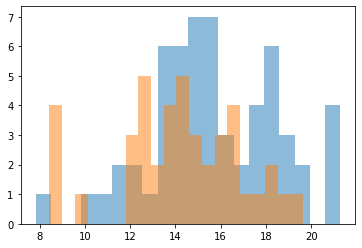

In [9]:
# see the distribution of B and D
b = one_pheno.loc[one_geno==0]
d = one_pheno.loc[one_geno==2]

plt.hist(b, alpha=0.5, bins=20)
plt.hist(d, alpha=0.5, bins=20)
plt.show()

### Perform a correlation test between *all* loci and one phenotype

Now that you have the `pearson_between` function to perform the correlation test between a genotype and a phenotype Series, you might as well `.apply` it to the enitre `geno2` DataFrame and calculate p-values for all loci.

Remember, the `apply` method acts on the DataFrame's columns by default, which is exactly what we need. It can also pass on extra keyword arguments to the function, so you can specify the `one_pheno` Series you want to correlate the different genotypes with.

Save the result under the name `one_pheno_vs_all_geno`.

In [10]:
one_pheno_vs_all_geno = geno2.apply(pearson_between, pheno=one_pheno)
one_pheno_vs_all_geno

Locus
rs6269442          0.639216
rs6365999          0.639216
rs6376963          0.538920
rs3677817          0.484253
rs8236463          0.270406
                     ...   
CEL-X_154259201    0.673234
rs3657281          0.673234
rs13484106         0.673234
gnfX.146.867       0.920509
DXMit223           0.869946
Length: 3811, dtype: float64

### Find the locus with the lowest p-value, and visualize the phenotype distribution for B and D genotypes

Create the same histogram again, except this time use the locus with the most significant PPearson's correlation to the phenotype (i.e. with the smallest p-value). You can either find the name of the locus by sorting and looking at the top, or using `.idxmin()`.

How is the separation on this plot compared to the last one?

- in this one, it is more separate, cause we get more data and normally D and B genotype will not queal and see some difference.

In [11]:
one_pheno_vs_all_geno.sort_values()

Locus
rs13481968       0.000004
gnf13.099.677    0.000004
rs13481970       0.000019
rs13481964       0.000028
rs6288680        0.000028
                   ...   
mCV25373751      0.996146
rs6215575        0.998316
rs13478720       0.998316
rs3693664        0.998709
D11Mit174        0.998709
Length: 3811, dtype: float64

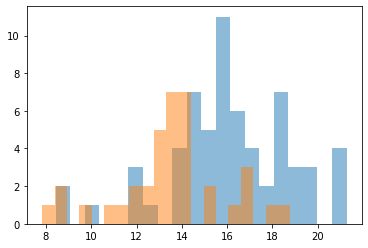

In [12]:
one_geno = geno2[one_pheno_vs_all_geno.idxmin()]
b = one_pheno.loc[one_geno==0]
d = one_pheno.loc[one_geno==2]

plt.hist(b, alpha=0.5, bins=20)
plt.hist(d, alpha=0.5, bins=20)
plt.show()

### Create a Manhattan plot for the `Glucose_[mmol/L]` phenotype

We see that there are a good bunch of SNPs that appear strongly associated with glucose levels in mice. Draw a Manhattan plot to see where they cluster on the genome, and do a bit of googling to confirm whether what you found is confirmed by the literature on the topic.

You should obviously re-use your code from the previous notebook to create the plot. You can (and of course should) perform a Benjamini-Hochberg correction on your p-values, but seeing the magnitude of the p-values, the best ones will clearly pass, and since we aren't planning to publish our findings, we won't complain if you just plot them as-is.

In [13]:
from statsmodels.sandbox.stats.multicomp import multipletests
geno_meta['p_raw'] = one_pheno_vs_all_geno
geno_meta['p_bh'] = multipletests(one_pheno_vs_all_geno, method='fdr_bh' )[1]

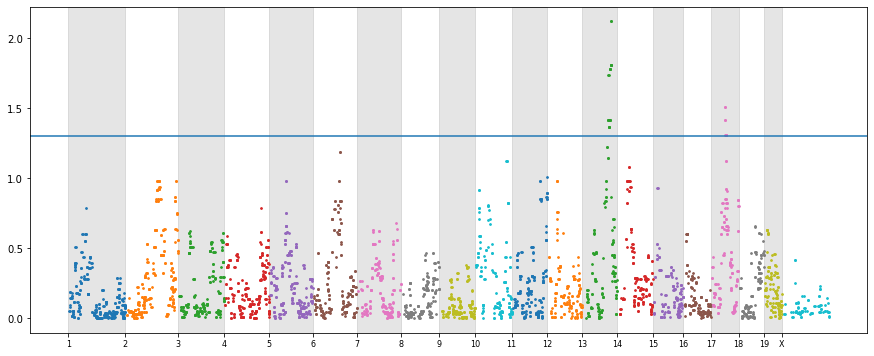

In [14]:
plt.figure(figsize=(15,6))
x_position = []
x_label = []
position = 0
for label, data in geno_meta.groupby("Chr", sort=False):
    x_position.append(position)
    x_label.append(label)
    plt.scatter(data['Mb']+position, -np.log10(data['p_bh']),s=3, zorder=2)
    position+=data['Mb'].max()
    
for x1, x2 in zip(x_position[::2], x_position[1::2]):
    plt.axvspan(x1, x2, color='black', alpha=0.1, zorder=1)
plt.axhline(-np.log10(0.05))
plt.xticks(x_position, x_label, fontsize=8)
plt.show()

### Perform a correlation test between all loci and all phenotypes of a sheet

The inevitable next step: running the Pearson correlation test between all pairs of loci and phenotypes.

If you can run the test between a single phenotype and all columns of `geno2`, you can also run it for every phenotype in the Biochemistry sheet: you just have to iterate over `phenotypes['Biochemistry']`'s columns using the DataFrame's `.iteritems()` method.

All you have to do is collect the resulting p-value Series in a list, concatenate them with `pd.concat` along the horizontal (`1`) axis, and name the columns. You can either name the columns after concatenation, but you can also think ahead and take care of it inside the iteration, right after each p-value Series has just been created. (If `pd.concat` receives a list of named Series, it will know how to name the columns of the concatenated DataFrame).

Name the resulting DataFrame `all_pheno_vs_all_geno`.

In [15]:
all_pheno_vs_all_geno = []
for (ind, data) in phenotypes['Biochemistry'].iteritems():
    all_pheno_vs_all_geno.append(geno2.apply(pearson_between, pheno=data))

In [16]:
# all_pheno_vs_all_geno = pd.concat(all_pheno_vs_all_geno, axis=1, keys = phenotypes['Biochemistry'].columns.tolist())
all_pheno_vs_all_geno

,Glucose_[mmol/L],Cholesterol_[mmol/L],HDL_Norm[Z],LDL_[mmol/L],Triglycerides_[mmol/L],FFA_Norm[Z],LacticAcid_[mmol/L],BloodProtein_[g/L],ASAT_[U/L],ASAT_Norm[Z],LDH_Norm[Z],ALPL_[U/L],Amylase_[U/L],CreatineKinase_[U/L],Creatinine_Norm[Z],Iron_[umol/L]
Locus,,,,,,,,,,,,,,,,
rs6269442,0.639216,0.936918,0.084360,0.703636,0.153500,0.573593,0.012397,0.207276,0.576868,0.354886,0.212520,0.726466,0.311665,0.802971,0.321784,0.051427
rs6365999,0.639216,0.936918,0.084360,0.703636,0.153500,0.573593,0.012397,0.207276,0.576868,0.354886,0.212520,0.726466,0.311665,0.802971,0.321784,0.051427
rs6376963,0.538920,0.292104,0.007315,0.619314,0.462597,0.954448,0.088569,0.068760,0.965035,0.795236,0.646737,0.958184,0.294992,0.926343,0.387400,0.241354
rs3677817,0.484253,0.407224,0.012659,0.700792,0.581830,0.764448,0.129011,0.173164,0.963443,0.771628,0.680533,0.606132,0.129128,0.786921,0.516501,0.103799
rs8236463,0.270406,0.329864,0.016015,0.369854,0.920659,0.565208,0.126123,0.514727,0.948199,0.819727,0.722554,0.081321,0.035787,0.875259,0.127825,0.887815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CEL-X_154259201,0.673234,0.935474,0.728436,0.740063,0.816703,0.767192,0.238692,0.308180,0.872766,0.926677,0.702482,0.072088,0.121074,0.382386,0.064120,0.755245
rs3657281,0.673234,0.935474,0.728436,0.740063,0.816703,0.767192,0.238692,0.308180,0.872766,0.926677,0.702482,0.072088,0.121074,0.382386,0.064120,0.755245
rs13484106,0.673234,0.935474,0.728436,0.740063,0.816703,0.767192,0.238692,0.308180,0.872766,0.926677,0.702482,0.072088,0.121074,0.382386,0.064120,0.755245


<AxesSubplot:ylabel='Locus'>

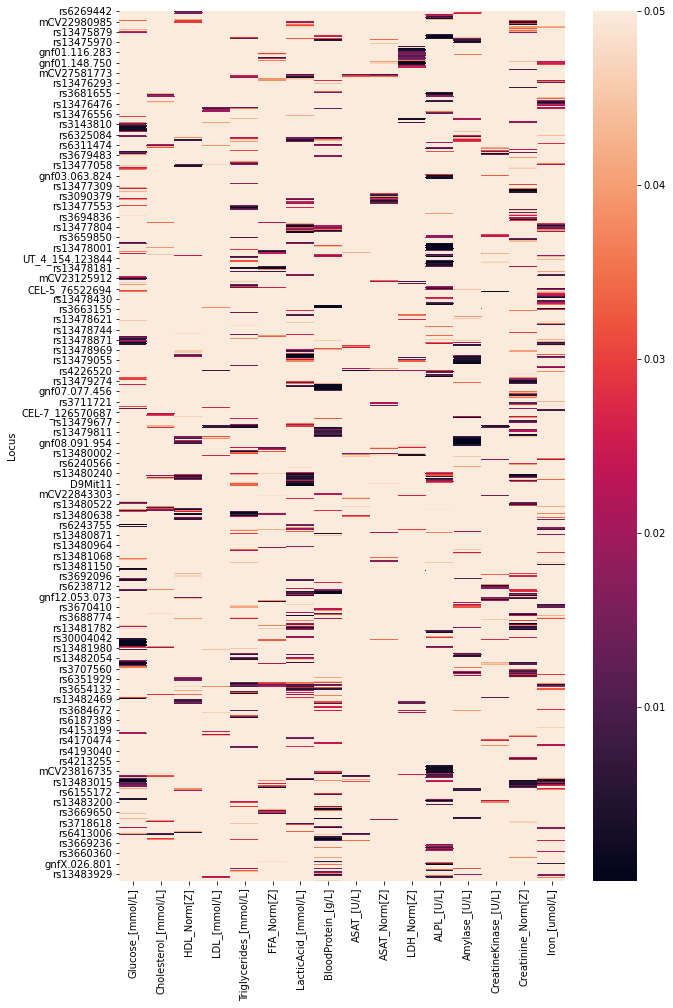

In [17]:
fig = plt.subplots(figsize=(10,16))
sns.heatmap(all_pheno_vs_all_geno.clip(upper=0.05))

### Create a Mann-Whitney U test function similar to `pearson_between`

The Mann-Whitney U test compares a strictly binary categorical variable with a continuous variable. Or in other words: it compares two groups of contiuous values.

Create a `mwu_between(one_geno, one_pheno)` function which performs the Mann-Whitney U test instead of Pearson's correlation. But watch out! The expected input of `stats.mannwhitneyu` is different from that of `stats.pearsonr`: instead of passing a genotype Series and a phenotype Series, you will have to pass two phenotype Series, one containing the phenotype values of B mice (`one_geno == 0`), and the other containing the phenotype values of D mice (`one_geno == 2`).

While having to slice `one_pheno` may seem like extra work, it has an upside: you don't have to bother with the parallel masking of `NaN` values, because `.dropna()` on both Series independently will do just fine.

Try out your `mwu_between` function on the same locus and phenotype that you had used when testing `pearson_between`.

In [18]:
# using  Mann-Whitney U test way to calculate the p values
def mwu_between(one_geno, one_pheno):
    p_value = stats.mannwhitneyu(one_pheno.loc[one_geno == 0].dropna(), one_pheno.loc[one_geno == 2].dropna()
                                ,alternative="two-sided")[1]
    return p_value

### Optional: calculate Mann-Whitney p-values for all loci-phenotype combinations for the Biochemistry sheet

This should be a copy-paste job. It will give you another big matrix with a lot of p-values in them. Let's call it `all_pheno_vs_all_geno_mwu`.
To make use of this data, create a scatter-plot comparing all of its values with the Pearson's p-values in `all_pheno_vs_all_geno`.

Hint 1: You can turn a numpy matrix into a 1-dimensional array with the `.flatten()` method. You can access a DataFrame's underlying numpy matrix with `.values`.

Hint 2: To "zoom in" on the interesting p-values, you can change your plot type to log-log (or equivalently, plot the log10 of the p-values).

In [20]:
all_pheno_vs_all_geno_mwu = []
for (ind, data) in phenotypes['Biochemistry'].iteritems():
    all_pheno_vs_all_geno_mwu.append(geno2.apply(mwu_between, one_pheno=data))

In [21]:
# all_pheno_vs_all_geno_mwu = pd.concat(all_pheno_vs_all_geno_mwu, axis=1, keys = phenotypes['Biochemistry'].columns.tolist())
all_pheno_vs_all_geno_mwu.head()

,Glucose_[mmol/L],Cholesterol_[mmol/L],HDL_Norm[Z],LDL_[mmol/L],Triglycerides_[mmol/L],FFA_Norm[Z],LacticAcid_[mmol/L],BloodProtein_[g/L],ASAT_[U/L],ASAT_Norm[Z],LDH_Norm[Z],ALPL_[U/L],Amylase_[U/L],CreatineKinase_[U/L],Creatinine_Norm[Z],Iron_[umol/L]
Locus,,,,,,,,,,,,,,,,
rs6269442,0.822245,0.957650,0.106318,0.409305,0.096423,0.142538,0.010935,0.311067,0.145912,0.100831,0.261006,1.000000,0.313028,0.397820,0.295215,0.140940
rs6365999,0.822245,0.957650,0.106318,0.409305,0.096423,0.142538,0.010935,0.311067,0.145912,0.100831,0.261006,1.000000,0.313028,0.397820,0.295215,0.140940
rs6376963,0.457230,0.449837,0.014098,0.970674,0.384285,0.574106,0.110239,0.097246,0.303327,0.352247,1.000000,0.740051,0.279070,0.490003,0.351667,0.645263
rs3677817,0.414048,0.654114,0.025611,0.905314,0.482807,0.867050,0.154609,0.207364,0.341308,0.352347,0.891502,0.280859,0.090454,0.487767,0.436967,0.423278
rs8236463,0.237590,0.530705,0.034153,0.593412,0.890623,0.955020,0.162896,0.571232,0.496830,0.490580,0.841054,0.081992,0.015068,0.874663,0.093508,0.996727


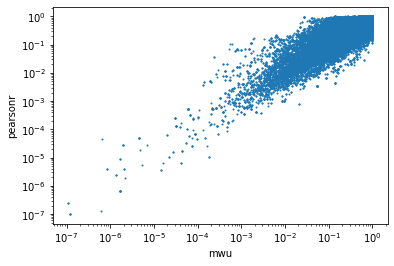

In [22]:
# plot scatter plot for two different way 
plt.scatter(all_pheno_vs_all_geno_mwu.values.flatten(), all_pheno_vs_all_geno.values.flatten(), s=1)
plt.xlabel('mwu')
plt.xscale('log')
plt.ylabel('pearsonr')
plt.yscale('log')

### Multiple testing correction

This is a tricky one. Having calculated p-values for every locus-phenotype pair, we now have a big matrix with tens of thousands of p-values. That's a lot of tests, and therefore they deserve a big, strict correction.

As you will find, the function `multipletests` can only deal with a 1-dimensional array of p-values. This means we will have to:
1. access the DataFrame's underlying numpy matrix with `.values`
2. flatten it into a 1d array
3. run `multipletests(..., method='fdr_bh')` on it
4. reshape it back to the original dimensions
5. turn it back to a DataFrame with the proper indices and columns.

These five steps will take four lines of code.

Are there any locus-phenotype associations that survive multiple testing correction?

And the question again: could we have overcorrected the data? Why?

- In statistic aspect, if x and y are independent, when the distribution will be sampling. However, when cdf under condition in p=0.05 is much more under, it is unusual and showing there are something effect our result, some where we can say it is over-correction.

In [23]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [35]:
## professor method
def BH_p_matrix(df, method='fdr_bh'):
    pval = fd.values.flatten()
    BH_pval = multipletests(p_valus_all, method=method)[1]
    BH_pval_matrix = pd.DataFrame(BH_pval.reshape(df)
                                    , columns=df.columns
                                    , index=df.index)

In [24]:
# using BH to correct the p value
p_valus_all = all_pheno_vs_all_geno_mwu.values.flatten()
BH_pval = multipletests(p_valus_all, method='fdr_bh' )[1]
all_pheno_vs_all_geno_BH_pval = pd.DataFrame(BH_pval.reshape(3811, 16)
                                            , columns=phenotypes['Biochemistry'].columns.tolist()
                                            , index=all_pheno_vs_all_geno_mwu.index)
all_pheno_vs_all_geno_BH_pval.head()

,Glucose_[mmol/L],Cholesterol_[mmol/L],HDL_Norm[Z],LDL_[mmol/L],Triglycerides_[mmol/L],FFA_Norm[Z],LacticAcid_[mmol/L],BloodProtein_[g/L],ASAT_[U/L],ASAT_Norm[Z],LDH_Norm[Z],ALPL_[U/L],Amylase_[U/L],CreatineKinase_[U/L],Creatinine_Norm[Z],Iron_[umol/L]
Locus,,,,,,,,,,,,,,,,
rs6269442,0.965709,0.997539,0.593492,0.832776,0.576816,0.635430,0.336195,0.775701,0.638130,0.585438,0.737524,1.000000,0.776743,0.826478,0.765141,0.634723
rs6365999,0.965709,0.997539,0.593492,0.832776,0.576816,0.635430,0.336195,0.775701,0.638130,0.585438,0.737524,1.000000,0.776743,0.826478,0.765141,0.634723
rs6376963,0.850823,0.848836,0.353769,0.999482,0.820145,0.891523,0.595442,0.577994,0.770211,0.799587,1.000000,0.943924,0.750802,0.863947,0.799587,0.917347
rs3677817,0.835139,0.919729,0.414555,0.983984,0.861266,0.976403,0.648717,0.701785,0.794598,0.799587,0.981907,0.752858,0.566263,0.863641,0.844103,0.839016
rs8236463,0.722134,0.878377,0.443385,0.898310,0.981907,0.996981,0.655366,0.891107,0.866430,0.863947,0.970169,0.553167,0.361291,0.978125,0.572155,1.000000


<AxesSubplot:ylabel='Locus'>

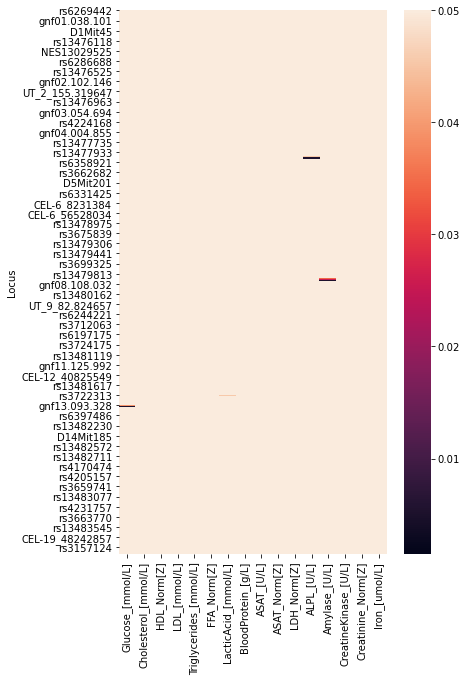

In [25]:
fig = plt.subplots(figsize=(6,10))
sns.heatmap(all_pheno_vs_all_geno_BH_pval.clip(upper=0.05))

In [37]:
(all_pheno_vs_all_geno.clip(upper=0.05) < 0.05).sum()/(all_pheno_vs_all_geno < 1).sum()

Glucose_[mmol/L]          0.139071
Cholesterol_[mmol/L]      0.044870
HDL_Norm[Z]               0.083967
LDL_[mmol/L]              0.033325
Triglycerides_[mmol/L]    0.127001
FFA_Norm[Z]               0.061926
LacticAcid_[mmol/L]       0.156914
BloodProtein_[g/L]        0.140121
ASAT_[U/L]                0.034899
ASAT_Norm[Z]              0.044345
LDH_Norm[Z]               0.059040
ALPL_[U/L]                0.154290
Amylase_[U/L]             0.096563
CreatineKinase_[U/L]      0.050905
Creatinine_Norm[Z]        0.160325
Iron_[umol/L]             0.140121
dtype: float64

In [36]:
(all_pheno_vs_all_geno_BH_pval.clip(upper=0.05) < 0.05).sum().sum()/len(all_pheno_vs_all_geno_BH_pval.values.flatten())

0.0009511939123589609

## What confounding factors may have influenced our analysis? How could they be dealt with?

Depending on how fast our progress was with the previous tasks, we may or may not go ahead and remove one such confounding factor. If we do it, we will document our questions in a separate supplementary notebook and upload it to the Github repo.

- I think it might be batch effect, becuase it these data, when we first look at the p value, showing some factor really effect locus, but some didn't.
- By this, when we also do multiple hypothesis test, the significant factor will effect in other, cause changes in the data produced by the experiment, and get the final result that all p value is too low for null hypothesis